# Train a LaTeX OCR model
In this brief notebook I show how you can finetune/train an OCR model.

I've opted to mix in handwritten data into the regular pdf LaTeX images. For that I started out with the released pretrained model and continued training on the slightly larger corpus.

In [1]:
import os
!mkdir -p LaTeX-OCR
os.chdir('LaTeX-OCR')

```
[global]
no-cache-dir = true
target=/home/coder/.local/lib/rolos-cardetection/site-packages
[user]
no-cache-dir = true
target=/home/coder/.local/lib/rolos-cardetection/site-packages
[site]
no-cache-dir = true
target=/usr/local/lib/crp-custom-env/site-packages
```

In [2]:
!mkdir -p dataset/data

In [3]:
# check what GPU we have
!gpustat

production-env-52271e230d654148a2da049797e801b5  Fri May 24 09:10:33 2024  535.104.05
[0] Tesla V100S-PCIE-32GB | 36°C,   0 % |     0 / 32768 MB |


In [4]:
from datasets import load_dataset

dataset = load_dataset('HuggingFaceM4/datikz')["train"]

/home/coder/.local/lib/rolos-cardetection/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
len(dataset)

48296

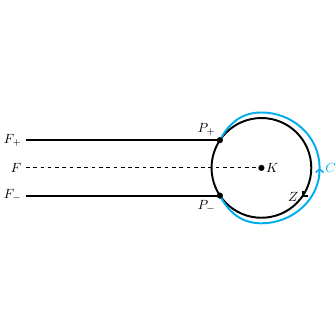

In [6]:
dataset[1]['image']

In [7]:
from tqdm import tqdm

lens = [len(row["code"]) for row in tqdm(dataset)]

100%|██████████| 48296/48296 [00:50<00:00, 962.09it/s] 


In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
print(lens)

[1241, 1033, 677, 3613, 1141, 788, 1019, 826, 45303, 982, 1226, 1001, 2010, 2997, 769, 2016, 816, 1012, 1125, 658, 868, 2211, 1319, 1234, 257, 255, 669, 2718, 2503, 4570, 1528, 469, 601, 706, 4988, 2385, 3626, 599, 970, 1754, 1219, 1158, 1648, 2203, 1958, 1059, 3788, 2042, 3160, 2845, 2505, 1159, 1526, 1053, 824, 764, 1963, 932, 1614, 1063, 849, 970, 1191, 2405, 1577, 2415, 2785, 2976, 1579, 1887, 1451, 1142, 1258, 1538, 2003, 2024, 1298, 925, 1436, 1058, 2115, 3217, 1918, 1123, 1200, 2072, 964, 1533, 753, 1823, 3151, 3114, 976, 756, 939, 1154, 779, 1923, 379, 718, 786, 634, 919, 1636, 779, 778, 955, 925, 772, 832, 687, 797, 1240, 814, 860, 782, 447, 859, 497, 986, 1038, 1206, 1448, 1082, 868, 790, 1018, 714, 1030, 1543, 996, 2108, 792, 1384, 1488, 483, 451, 20380, 1558, 2331, 1670, 1670, 1548, 1102, 1443, 2002, 2677, 2768, 1990, 3600, 2017, 370, 485, 501, 1024, 439, 607, 893, 663, 985, 434, 620, 516, 422, 840, 1593, 918, 1152, 945, 1840, 525, 935, 798, 1986, 1338, 975, 723, 1299, 1196

In [15]:
l = np.array(lens)

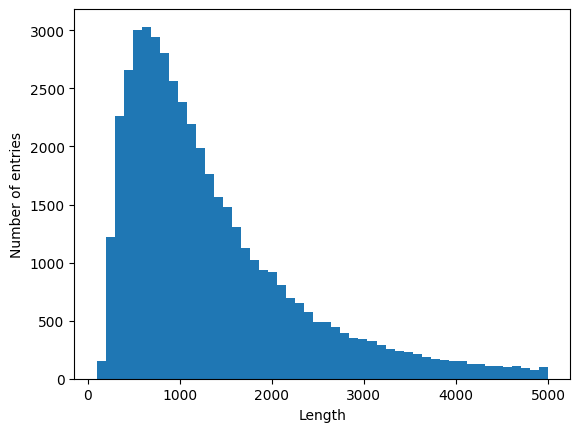

In [17]:
plt.hist(l[l <= 5000], bins=50)
plt.xlabel("Length")
plt.ylabel("Number of entries")

plt.show()

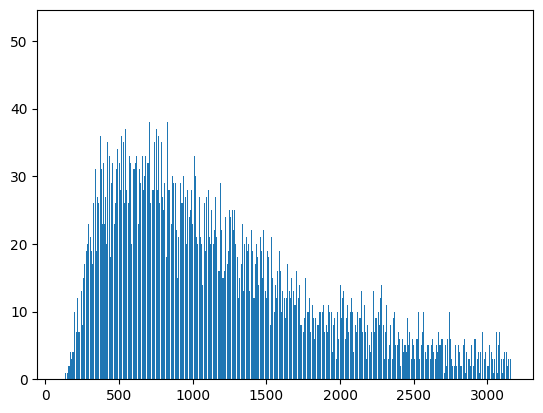

In [8]:


u, v = np.unique(lens, return_counts=True)
plt.bar(u[:3000], v[:3000])
plt.show()

In [9]:
print(u[200], np.sum(v[:200]))

348 2467


In [10]:
trim_len = 1500

In [11]:
filtered_dataset = dataset.filter(lambda item: len(item["code"]) < trim_len)

In [12]:
print(len(filtered_dataset))

30948


In [14]:
from tqdm import tqdm
import os
import random

def create_dir(*params):
  d = os.path.join(*params)
  if not os.path.exists(d):
    os.mkdir(d)
  return d

tikz_images_dir = create_dir("./dataset/data", "tikz_images")

train_images_dir = create_dir(tikz_images_dir, "train")
val_images_dir = create_dir(tikz_images_dir, "val")
test_images_dir = create_dir(tikz_images_dir, "test")

target_file = "./dataset/data/tikz_text.txt"

train_size = int(0.8 * len(filtered_dataset))
# val_size = len(filtered_dataset) - train_size 
val_size = int(0.1 * len(filtered_dataset))
test_size = len(filtered_dataset) - train_size - val_size

random.seed(42)
assignment = [0] * train_size + [1] * val_size + [2] * test_size
random.shuffle(assignment)
to_save = { 0: train_images_dir, 1: val_images_dir, 2: test_images_dir }

with open(target_file, "w") as f:
  for i, (data, split) in tqdm(enumerate(zip(filtered_dataset, assignment)), total=len(filtered_dataset)):
    to_save_dir = to_save[split]

    filename = "0" * (7 - len(str(i))) + str(i)

    data["image"].save(os.path.join(to_save_dir, f"{filename}.png"))
    f.write(data["code"].replace("\n", "\\n") + "[EOS]\n")


  0%|          | 0/30948 [00:00<?, ?it/s]

100%|██████████| 30948/30948 [02:46<00:00, 185.62it/s]


In [15]:
train_size, val_size, test_size

(24758, 3094, 3096)

Now we generate the datasets. We can string multiple datasets together to get one large lookup table. The only thing saved in these pkl files are image sizes, image location and the ground truth latex code. That way we can serve batches of images with the same dimensionality.

In [16]:
!pwd
!ls -l ./dataset/data/images | wc -l

/home/coder/project/LaTeX-OCR
ls: cannot access './dataset/data/images': No such file or directory
0


In [17]:
!python -m pix2tex.dataset.dataset -i dataset/data/tikz_images/train -e dataset/data/tikz_text.txt -o dataset/data/train.pkl

Generate dataset
100%|██████████████████████████████████| 24758/24758 [00:00<00:00, 75170.51it/s]


In [18]:
!python -m pix2tex.dataset.dataset -i dataset/data/tikz_images/val -e dataset/data/tikz_text.txt -o dataset/data/val.pkl

Generate dataset
100%|████████████████████████████████████| 3094/3094 [00:00<00:00, 69820.07it/s]


In [19]:
# download the weights we want to fine tune
!curl -L -o weights.pth https://github.com/lukas-blecher/LaTeX-OCR/releases/download/v0.0.1/weights.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 97.3M  100 97.3M    0     0  77.5M      0  0:00:01  0:00:01 --:--:--  115M


In [20]:
# If using wandb
!pip install -q wandb
# you can cancel this if you don't wan't to use it or don't have a W&B acc.
#!wandb login

In [23]:
# generate colab specific config (set 'debug' to true if wandb is not used)
!echo \{backbone_layers: \[2, 3, 7\], betas: \[0.9, 0.999\], batchsize: 8, bos_token: 1, channels: 1, data: dataset/data/train.pkl, debug: true, decoder_args: \{'attn_on_attn': true, 'cross_attend': true, 'ff_glu': true, 'rel_pos_bias': false, 'use_scalenorm': false\}, dim: 256, encoder_depth: 4, eos_token: 2, epochs: 50, gamma: 0.9995, heads: 8, load_chkpt: "/home/coder/project/LaTeX-OCR/weights.pth", id: null, lr: 0.001, lr_step: 30, max_height: 336, max_seq_len: 2048, max_width: 336, min_height: 32, min_width: 32, model_path: checkpoints, name: mixed, num_layers: 4, num_tokens: 8000, optimizer: Adam, output_path: outputs, pad: false, pad_token: 0, patch_size: 16, sample_freq: 2000, save_freq: 1, scheduler: StepLR, seed: 42, temperature: 0.2, test_samples: 5, testbatchsize: 8, tokenizer: dataset/tokenizer.json, valbatches: 1, valdata: dataset/data/val.pkl\} > colab.yaml

In [4]:
import wandb
wandb.login(key="537a87ee9f58975753d0095857b13b7604476474")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: iluxa-kholkin (graphene). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/coder/.netrc


True

In [6]:
!python -m pix2tex.train --config colab.yaml

/home/coder/.local/lib/rolos-cardetection/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
wandb: Currently logged in as: iluxa-kholkin (graphene). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /home/coder/project/LaTeX-OCR/wandb/run-20240523_123747-1s0ximo2
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run mixed
wandb: ⭐️ View project at https://wandb.ai/graphene/project-LaTeX-OCR
wandb: 🚀 View run at https://wandb.ai/graphene/project-LaTeX-OCR/runs/1s0ximo2
Failed to load encoder.pos_embed from original model: The size of tensor a (442) must ma